# TP2 - COMPUTER VISION I
Alumno: Diego Araujo

**Objetivo:**

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper *"Image Sharpness Measure for Blurred Images in Frequency Domain“* y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del areatotal del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxMelementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames dónde se detecta la condición de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shape from focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [1]:
# ---------------- Paquetes a utilizar ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


import cv2 as cv


## Parte 1

### Algoritmo de enfoque | Funciones Auxiliares

Se escribe el algoritmo (`image_quality_measure`) descripto en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y se utiliza luego para detectar zonas de enfoque del video, según medida de cada frame.

La función auxiliar `enfoque_video`, toma el output de `image_quality_measure` y devuelve valor umbral de la métrica  utilizada (en este caso percentiles) para detectar enfoque, los frames enfocados  y la salida gráfica. 

Otras funciones auxiliares son las de procesamiento del video en los formatos que piden los experimentos: en todo el frame (`FULL`), en una región de interés (`ROI`) o en una grilla de arreglos NxM dentro de una región de interés (`gridROI`).

In [2]:
# ---------------- Algoritmo para medir Calidad de Imagen ----------------

def image_quality_measure(img):

    '''
    Input:      Imagen de M x N
    Output:     Medida de la calidad de la imagen (FM)
                FM = medida del desenfoque de la imagen en el dominio de la frecuencia

    '''

    # 1) Tranformada de Fourier
    TF = np.fft.fft2(img)

    # 2) Se lleva la baja frecuencia al origen 
    Fc = np.fft.fftshift(TF)
    
    # 3) Se calcula AF = abs(Fc)
    AF = np.abs(Fc)
    
    # 4) Se calcula M = max(AF)
    M = np.max(AF)
    
    # 5) Se calcula TH = número total de píxeles en F donde valor de píxel > M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # 6) Medida de la calidad de la imagen (FM)
    FM = TH / (img.shape[0] * img.shape[1])

    return FM


In [3]:
# ---------------- Algoritmo para procesar video y detectar zonas de enfoque ----------------

def enfoque_video(FM, perc, plot = False, title_plot = None, focus_color = 'limegreen', desenfoc_color = 'tomato'):
    """
    Inputs:
    array_enfoque:      Array que contiene las medidas de enfoque para cada frame.
    percentil:          Percentil que se utilizará para definir la zona de enfoque.

    Outputs:
    gráfico
    frames_enfocados:   Dataframe de los frames que cumplen con el criterio de enfoque.
    """

    # Se convierte a DataFrame para tener pares de frame / medida de enfoque
    exp = pd.DataFrame({'frame': range(len(FM)), 'FM': FM})

    # Métrica objetivo para definir zona de enfoque
    metric = np.percentile(exp['FM'], q=perc)
    
    # Punto máximo
    max_metric = np.max(exp['FM'])
    max_frame = exp[exp['FM'] == max_metric]['frame']

    # Se guardan los índices que están enfocados para detectar en video después
    frames_enfocados = np.where(exp['FM'] >= metric, exp['frame'], None)
    frames_enfocados = frames_enfocados[frames_enfocados != None]

    if plot == True:
            # Se dibuja el gráfico para detectar zonas de enfoque
            plt.figure(figsize=(15, 5))

            # Línea horizontal para mostrar el límite de la métrica
            plt.axhline(y=metric, color='forestgreen', linestyle='dotted', label=f'Valor métrica perc. {perc}')

            # Gráfico de enfoque por frame (verde para enfocado, rojo para desenfocado)
            plt.scatter(exp['frame'][exp['FM'] >= metric], exp['FM'][exp['FM'] >= metric], 
                        color=focus_color, label='Zona enfocada')
            plt.scatter(exp['frame'][exp['FM'] < metric], exp['FM'][exp['FM'] < metric], 
                        color=desenfoc_color, label='Zona desenfocada')
            
            # Punto máximo
            plt.scatter(max_frame, max_metric, 
                        color='navy', label='Punto de enfoque máximo')

            # Título y etiquetas
            plt.title(title_plot)
            plt.xlabel('Frame')
            plt.ylabel('Medida de enfoque')
            plt.legend()
            plt.grid(color='lightgray', alpha=0.5)
            plt.show()

    return metric, exp.loc[frames_enfocados,:]

In [4]:
# ---------------- Función para procesar el video FULL ----------------

def process_video_FULL(video_path):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Experimento 1
        fm_full = image_quality_measure(gray_frame)

        focus_measure.append(fm_full)
        

    cap.release()
    return(focus_measure)

In [5]:
# ---------------- Función para procesar el video ROI ----------------

def process_video_ROI(video_path, size = 0.1):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        height, width = gray_frame.shape

        # Punto medio para ubicar ROI
        med_h = height // 2
        med_w = width // 2

        # ROI
        area_ROI_h = int(size * height)  # Area de ROI = % size del total
        area_ROI_w = int(size * width)

        min_height = med_h - (area_ROI_h // 2)
        max_height = med_h + (area_ROI_h // 2)
        min_width =  med_w - (area_ROI_w // 2)
        max_width =  med_w + (area_ROI_w // 2)

        gray_frame = gray_frame[min_width:max_width, min_height:max_height]
        
        fm_ROI = image_quality_measure(gray_frame)

        focus_measure.append(fm_ROI)
        

    cap.release()
    return(focus_measure)

In [6]:
# ---------------- Función para dibujar la grilla en ROI ----------------

def draw_spaced_grid(frame, num_rows, num_cols, square_size=20, spacing=15, color=(0, 0, 255), thickness=2):
    
    h, w, _ = frame.shape
    
    grid_height = num_rows * (square_size + spacing)
    grid_width = num_cols * (square_size + spacing)
    
    
    start_x = (w - grid_width) // 2
    start_y = (h - grid_height) // 2
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            top_left = (start_x + j * (square_size + spacing), start_y + i * (square_size + spacing))
            bottom_right = (top_left[0] + square_size, top_left[1] + square_size)
            cv.rectangle(frame, top_left, bottom_right, color, thickness)
    
    return frame

In [7]:
# ---------------- Función para procesar el video gridROI ----------------

def process_video_gridROI(video_path, N, M):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Se convierte a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        height, width = gray_frame.shape

        # Tamaño de cada rectángulo en la matriz NxM
        rect_height = height // N
        rect_width = width // M

        # Lista para almacenar las medidas de enfoque de cada ROI
        fm_ROIs = []

        # Se recorren cada uno de los NxM rectángulos de la grilla
        for i in range(N):
            for j in range(M):
                # Definir los límites del ROI
                min_h = i * rect_height
                max_h = (i + 1) * rect_height
                min_w = j * rect_width
                max_w = (j + 1) * rect_width

                # se extrae el ROI correspondiente a cada rectángulo
                roi = gray_frame[min_h:max_h, min_w:max_w]
                
                # Se calcula la medida de enfoque de este ROI
                fm_ROI = image_quality_measure(roi)
                fm_ROIs.append(fm_ROI)
        
        # Se agrega el promedio de las medidas de enfoque de este frame
        focus_measure.append(np.mean(fm_ROIs))

    cap.release()
    return focus_measure

### Experimento 1 - Medición sobre todo el frame

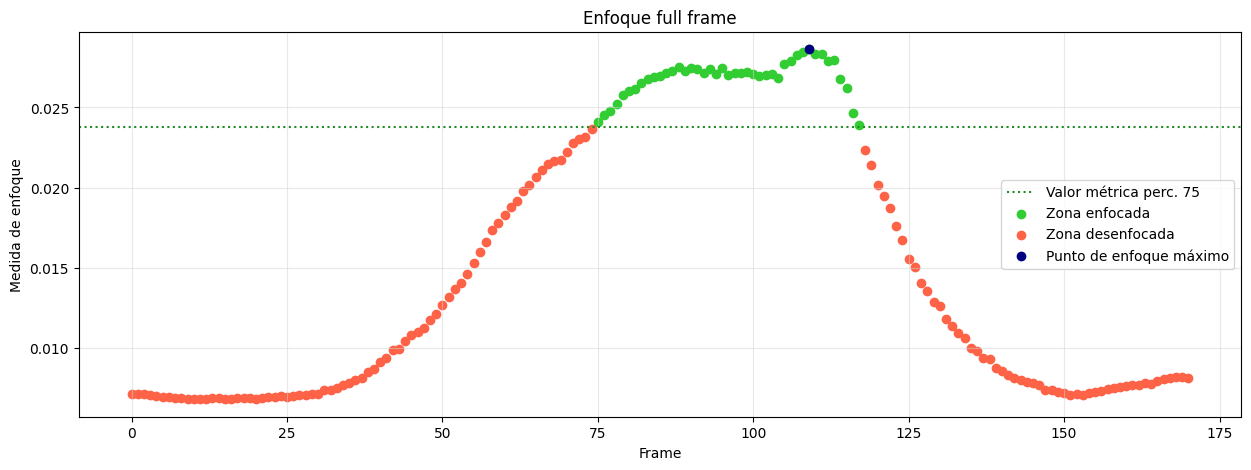

Valor de métrica: 0.0238 

     frame        FM
75      75  0.024102
76      76  0.024497
77      77  0.024766
78      78  0.025221
79      79  0.025794
80      80  0.026020
81      81  0.026176
82      82  0.026523
83      83  0.026749
84      84  0.026914
85      85  0.026957
86      86  0.027131
87      87  0.027270
88      88  0.027504
89      89  0.027270
90      90  0.027461
91      91  0.027409
92      92  0.027140
93      93  0.027383
94      94  0.027088
95      95  0.027470
96      96  0.027044
97      97  0.027166
98      98  0.027148
99      99  0.027201
100    100  0.027053
101    101  0.026966
102    102  0.027036
103    103  0.027079
104    104  0.026810
105    105  0.027730
106    106  0.027895
107    107  0.028251
108    108  0.028424
109    109  0.028624
110    110  0.028320
111    111  0.028346
112    112  0.027886
113    113  0.027947
114    114  0.026784
115    115  0.026237
116    116  0.024657
117    117  0.023928


In [8]:
# Se procesa el video
exp1 = process_video_FULL('focus_video.mov')

# Se calculan las métricas y los frames enfocados
metrica, df_enfoque = enfoque_video(FM = exp1, perc=75, plot=True, title_plot='Enfoque full frame')
print(f'Valor de métrica: {np.round(metrica,4)} \n')
print(df_enfoque)

In [9]:
# ---------------- Reproducción del video ----------------

# Carga del video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)


if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

    # Si hay que redimensionar, lo hacemos acá
    new_width = frame_width // 1
    new_height = frame_height // 1
    
    # Se obtiene la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    

    # Loop para detectar zonas enfocadas / desenfocadas
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        bbox_start = (0, new_height)
        bbox_end = (new_width, 0)
        
        if i in df_enfoque['frame']:
            # Se muestra el frame verde en caso de máximo enfoque
            cv.rectangle(frame, bbox_start, bbox_end, (0,255,0),10)
        else:
            # Se muestra el frame rojo si no está en condición de máximo enfoque
            cv.rectangle(frame, bbox_start, bbox_end, (0,0,255), 10)
        
        cv.imshow('Medicion de enfoque en full frame', frame)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break
        

# Se libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()


### Experimento 2 - Medición sobre una ROI ubicada en el centro del frame (10% del total)

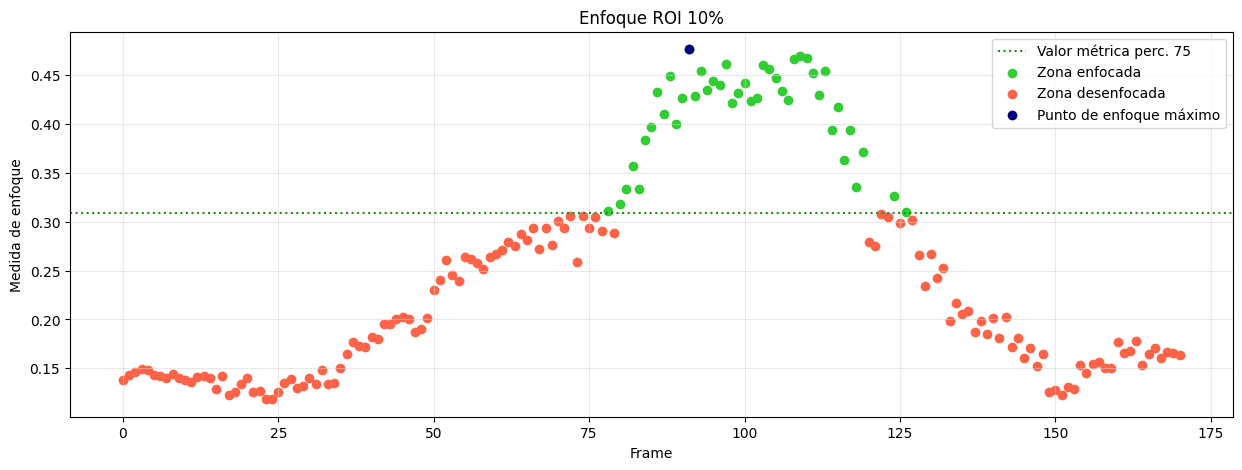

Valor de métrica: 0.3086 

     frame        FM
78      78  0.311198
80      80  0.318142
81      81  0.333767
82      82  0.356337
83      83  0.333767
84      84  0.383247
85      85  0.397135
86      86  0.432726
87      87  0.410156
88      88  0.448351
89      89  0.399740
90      90  0.426649
91      91  0.476128
92      92  0.428385
93      93  0.453559
94      94  0.434896
95      95  0.443576
96      96  0.439670
97      97  0.461372
98      98  0.421441
99      99  0.430990
100    100  0.441406
101    101  0.423177
102    102  0.426649
103    103  0.459635
104    104  0.455729
105    105  0.446615
106    106  0.433594
107    107  0.424045
108    108  0.465712
109    109  0.469184
110    110  0.467448
111    111  0.451823
112    112  0.429253
113    113  0.453559
114    114  0.393663
115    115  0.417101
116    116  0.363281
117    117  0.393229
118    118  0.335069
119    119  0.371094
124    124  0.325955
126    126  0.309462


In [10]:
# Se procesa el video
ROI_size = 0.1
exp2 = process_video_ROI('focus_video.mov', size=ROI_size)

metrica, df_enfoque = enfoque_video(FM = exp2, perc=75, plot=True, title_plot= 'Enfoque ROI 10%')
print(f'Valor de métrica: {np.round(metrica,4)} \n')
print(df_enfoque)


In [11]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)


if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)

    # Punto medio para ubicar ROI
    med_h = frame_height // 2
    med_w = frame_width // 2

    # ROI
    area_ROI_h = int(ROI_size * frame_height)  # Area de ROI = 10% del total
    area_ROI_w = int(ROI_size * frame_width)

    min_height = med_h - (area_ROI_h // 2)
    max_height = med_h + (area_ROI_h // 2)
    min_width =  med_w - (area_ROI_w // 2)
    max_width =  med_w + (area_ROI_w // 2)
    
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        bbox_start = (min_width, max_height)
        bbox_end = (max_width, min_height)
        
        # Si el frame está enfocado aparece en verde, sino en rojo
        if i in df_enfoque['frame']:
            cv.rectangle(frame, bbox_start, bbox_end, (0,255,0),2)
        else:
            cv.rectangle(frame, bbox_start, bbox_end, (0,0,255), 2)
        
        cv.imshow('Medicion de enfoque en ROI', frame)

        i += 1

        # Para salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break
        

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

### Experimento 3 - Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos.

#### Experimento en grilla 3 x 3 

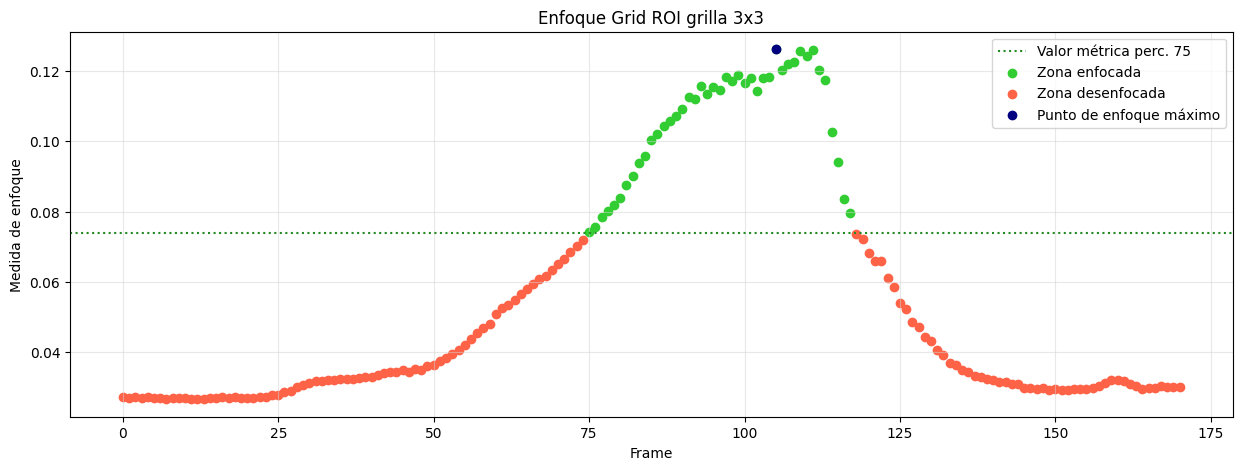

Valor de métrica: 0.074 

     frame        FM
75      75  0.074165
76      76  0.075678
77      77  0.078395
78      78  0.080238
79      79  0.081838
80      80  0.083872
81      81  0.087611
82      82  0.090010
83      83  0.093962
84      84  0.095822
85      85  0.100456
86      86  0.102095
87      87  0.104451
88      88  0.105756
89      89  0.107347
90      90  0.109129
91      91  0.112650
92      92  0.112076
93      93  0.115780
94      94  0.113598
95      95  0.115506
96      96  0.114693
97      97  0.118249
98      98  0.117075
99      99  0.118931
100    100  0.116606
101    101  0.117936
102    102  0.114315
103    103  0.117927
104    104  0.118271
105    105  0.126200
106    106  0.120279
107    107  0.121992
108    108  0.122600
109    109  0.125800
110    110  0.124200
111    111  0.126095
112    112  0.120383
113    113  0.117532
114    114  0.102743
115    115  0.094084
116    116  0.083616
117    117  0.079712


In [12]:
# Se procesa el video
N = 3
M = 3
exp3 = process_video_gridROI('focus_video.mov', N = N, M = M)
exp3

# Se calculan las métricas y los frames enfocados
metrica, df_enfoque = enfoque_video(FM = exp3, perc=75, plot=True, title_plot= 'Enfoque Grid ROI grilla 3x3')
print(f'Valor de métrica: {np.round(metrica,4)} \n')
print(df_enfoque)

In [13]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
  
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)

    i = 0

    while captura_video.isOpened():
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Se dibuja la grilla de color verde si está enfocada, en caso contrario en rojo
        if i in df_enfoque['frame']:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 255, 0))
        else:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 0, 255))

        cv.imshow('Medicion de enfoque en grilla equiespaciada 3x3', frame_with_grid)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break   

captura_video.release()
cv.destroyAllWindows()

#### Experimento en grilla 7 x 7

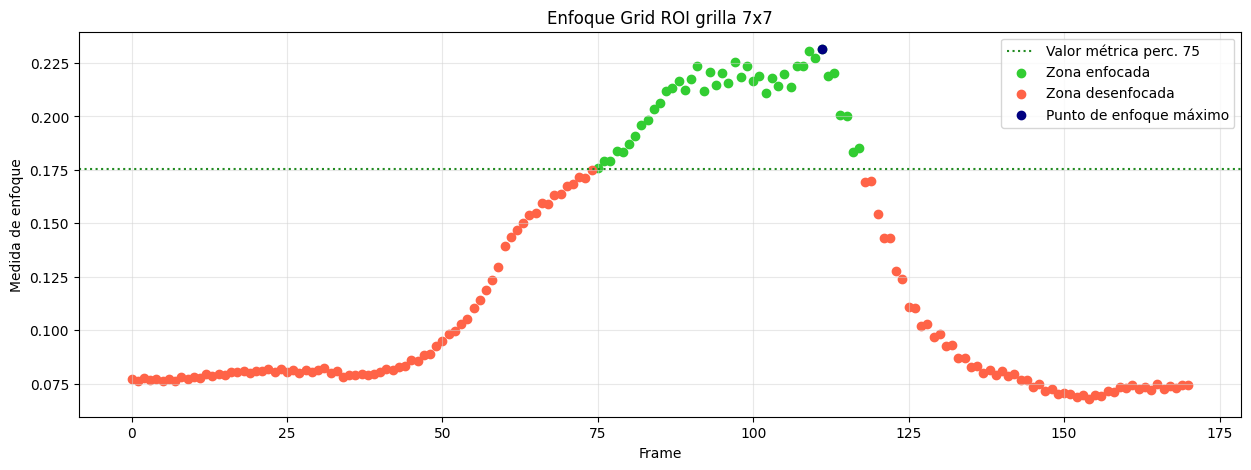

Valor de métrica: 0.1753 

     frame        FM
75      75  0.175829
76      76  0.179232
77      77  0.179250
78      78  0.184008
79      79  0.183445
80      80  0.187156
81      81  0.190824
82      82  0.196136
83      83  0.198457
84      84  0.203312
85      85  0.206074
86      86  0.211834
87      87  0.213259
88      88  0.216390
89      89  0.212168
90      90  0.217551
91      91  0.223549
92      92  0.211887
93      93  0.220576
94      94  0.214763
95      95  0.220260
96      96  0.215739
97      97  0.225255
98      98  0.218536
99      99  0.223795
100    100  0.216372
101    101  0.219072
102    102  0.210928
103    103  0.217762
104    104  0.214235
105    105  0.219758
106    106  0.213576
107    107  0.223364
108    108  0.223830
109    109  0.230602
110    110  0.227374
111    111  0.231446
112    112  0.218879
113    113  0.220541
114    114  0.200480
115    115  0.199988
116    116  0.183550
117    117  0.185274


In [14]:
# Se procesa el video
N = 7
M = 7
exp3 = process_video_gridROI('focus_video.mov', N = N, M = M)
exp3

# Se calculan las métricas y los frames enfocados
metrica, df_enfoque = enfoque_video(FM = exp3, perc=75, plot=True, title_plot= 'Enfoque Grid ROI grilla 7x7')
print(f'Valor de métrica: {np.round(metrica,4)} \n')
print(df_enfoque)

In [15]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
  
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)

    i = 0

    while captura_video.isOpened():
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Se dibuja la grilla de color verde si está enfocada, en caso contrario en rojo
        if i in df_enfoque['frame']:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 255, 0))
        else:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 0, 255))

        cv.imshow('Medicion de enfoque en grilla equiespaciada 7x7', frame_with_grid)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break   

captura_video.release()
cv.destroyAllWindows()

#### Experimento en grilla 7 x 5

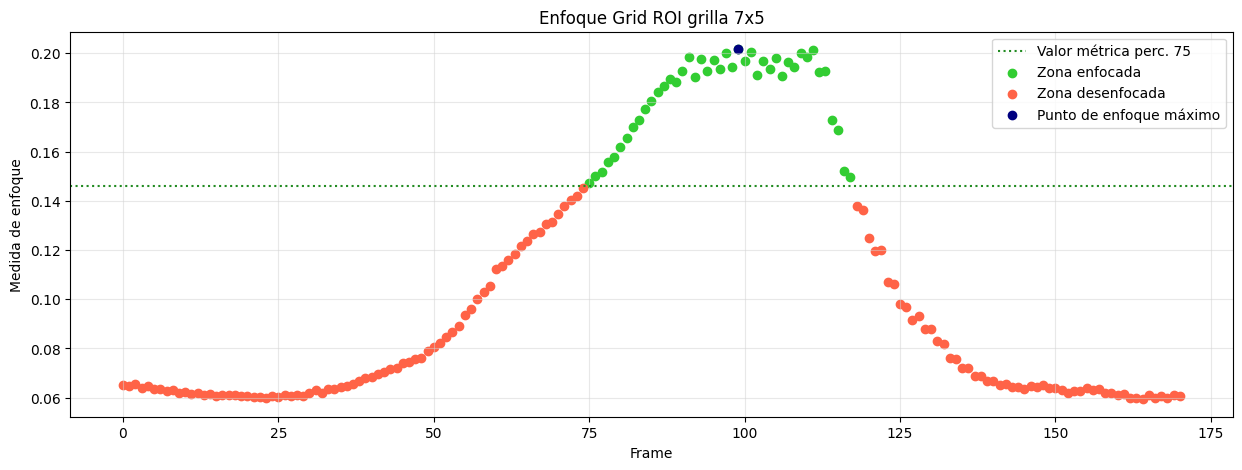

Valor de métrica: 0.1462 

     frame        FM
75      75  0.147260
76      76  0.150263
77      77  0.151668
78      78  0.155786
79      79  0.157734
80      80  0.162062
81      81  0.165734
82      82  0.169849
83      83  0.172772
84      84  0.177175
85      85  0.180694
86      86  0.184239
87      87  0.186616
88      88  0.189329
89      89  0.188143
90      90  0.192844
91      91  0.198608
92      92  0.190380
93      93  0.197755
94      94  0.192796
95      95  0.197256
96      96  0.193584
97      97  0.200228
98      98  0.194271
99      99  0.201606
100    100  0.196849
101    101  0.200284
102    102  0.191190
103    103  0.196748
104    104  0.193452
105    105  0.198232
106    106  0.190546
107    107  0.196591
108    108  0.194240
109    109  0.200223
110    110  0.198324
111    111  0.201282
112    112  0.192419
113    113  0.192870
114    114  0.172820
115    115  0.168846
116    116  0.152202
117    117  0.149777


In [16]:
# Se procesa el video
N = 7
M = 5
exp3 = process_video_gridROI('focus_video.mov', N = N, M = M)
exp3

# Se calculan las métricas y los frames enfocados
metrica, df_enfoque = enfoque_video(FM = exp3, perc=75, plot=True, title_plot= 'Enfoque Grid ROI grilla 7x5')
print(f'Valor de métrica: {np.round(metrica,4)} \n')
print(df_enfoque)

In [17]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
  
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)

    i = 0

    while captura_video.isOpened():
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Se dibuja la grilla de color verde si está enfocada, en caso contrario en rojo
        if i in df_enfoque['frame']:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 255, 0))
        else:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 0, 255))

        cv.imshow('Medicion de enfoque en grilla equiespaciada 7x5', frame_with_grid)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break   

captura_video.release()
cv.destroyAllWindows()

### Unsharp Masking

Para el unsharp masking, se utiliza el procesamiento del primer experimento (`FULL`) y se aplica primero para todos los frames (ya sean enfocados o desenfocados) y luego únicamente en la zonas de desenfoque.

In [18]:
def unsharp_masking(image, kernel_size=(5, 5), sigma=1, amount=2, threshold=0):
    
    blurred = cv.GaussianBlur(image, kernel_size, sigma) #;print(blurred)

    sharpened = float(amount + 1) * image - float(amount) * blurred

    # Para llevar los valores entre rangos de 0-255
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))

    sharpened = sharpened.round().astype(np.uint8)
    
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)

    return sharpened

In [19]:
def process_video_UM(video_path, focus_threshold=100):
    cap = cv.VideoCapture(video_path)
    focus_measure = []  # Lista para guardar las métricas de enfoque

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Métrica de calidad en el frame completo
        fm_full = image_quality_measure(gray_frame)

        # Si la métrica de enfoque es menor que el umbral, se aplica Unsharp Masking
        if fm_full < focus_threshold:
            gray_frame = unsharp_masking(gray_frame)
            fm_full = image_quality_measure(gray_frame)  # Se recalcula la métrica sobre el frame procesado
        
        # Guardar el valor de la métrica (fm_full)
        focus_measure.append(fm_full)
    
    cap.release()
    
    return focus_measure

#### Aplicación de unsharp masking sobre todos los frames

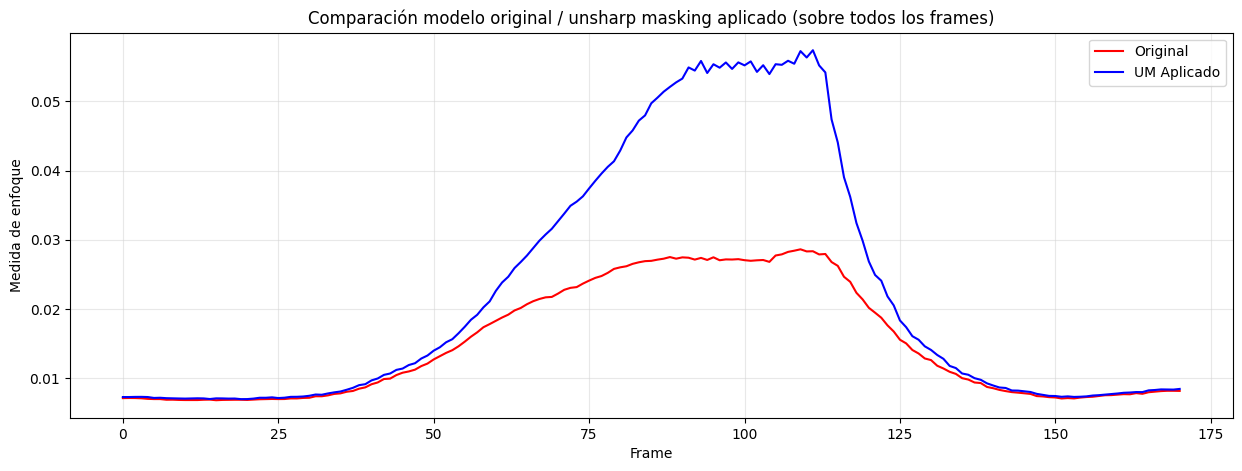

In [20]:
# Se procesa el video
exp1 = process_video_FULL('focus_video.mov')
expUM = process_video_UM('focus_video.mov') # Este era el umbral de enfoque del experimento original

# Se calculan las métricas y los frames enfocados
# Se convierte a DataFrame para tener pares de frame / medida de enfoque
exp1 = pd.DataFrame({'frame': range(len(exp1)), 'FM': exp1})
expUM = pd.DataFrame({'frame': range(len(expUM)), 'FM': expUM})

# Se dibuja el gráfico para detectar zonas de enfoque
plt.figure(figsize=(15, 5))

# Línea horizontal para mostrar el límite de la métrica
#plt.axhline(y=metric, color='forestgreen', linestyle='dotted', label=f'Valor métrica perc. {perc}')

# Gráfico de enfoque por frame (verde para enfocado, rojo para desenfocado)
plt.plot(exp1['FM'], color='red', label='Original')
plt.plot(expUM['FM'],color='blue', label='UM Aplicado')

# Título y etiquetas
plt.title('Comparación modelo original / unsharp masking aplicado (sobre todos los frames)')
plt.xlabel('Frame')
plt.ylabel('Medida de enfoque')
plt.legend()
plt.grid(color='lightgray', alpha=0.5)
plt.show()


In [21]:
# ---------------- Reproducción del video ----------------

# Carga del video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Se obtiene la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    
    # Loop para detectar zonas enfocadas / desenfocadas
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Definimos el tamaño del bounding box (enfoque/no enfoque)
        new_height, new_width, _ = frame.shape
        bbox_start = (0, new_height)
        bbox_end = (new_width, 0)
        
        frame = unsharp_masking(frame) # Se aplica sobre todos los frames enfocados / desenfocados

        # Si el frame está en el dataframe de enfoque, marcamos verde
        if i in df_enfoque['frame']:
            cv.rectangle(frame, bbox_start, bbox_end, (0, 255, 0), 10)
        else:
            cv.rectangle(frame, bbox_start, bbox_end, (0, 0, 255), 10) 
                   
        # Mostramos el frame con las anotaciones
        cv.imshow('Aplicacion de unsharp masking en full frame', frame)

        i += 1
        

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

# Se libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

#### Aplicación de unsharp masking únicamente sobre los frames desenfocados

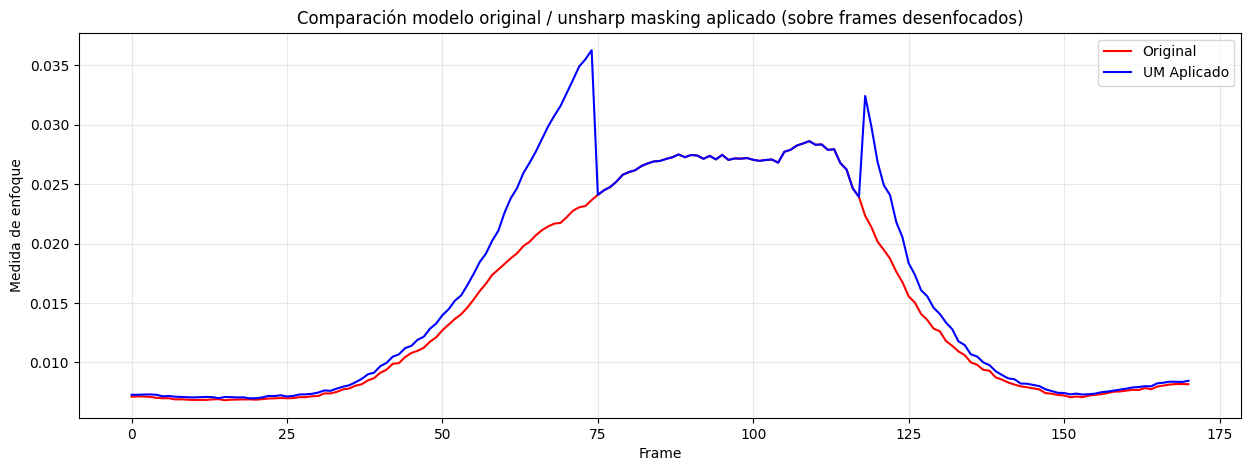

In [22]:
# Se procesa el video
exp1 = process_video_FULL('focus_video.mov')
expUM = process_video_UM('focus_video.mov', focus_threshold=0.0238) # Este era el umbral de enfoque del experimento original

# Se calculan las métricas y los frames enfocados
# Se convierte a DataFrame para tener pares de frame / medida de enfoque
exp1 = pd.DataFrame({'frame': range(len(exp1)), 'FM': exp1})
expUM = pd.DataFrame({'frame': range(len(expUM)), 'FM': expUM})


# Se dibuja el gráfico para detectar zonas de enfoque
plt.figure(figsize=(15, 5))

# Línea horizontal para mostrar el límite de la métrica
#plt.axhline(y=metric, color='forestgreen', linestyle='dotted', label=f'Valor métrica perc. {perc}')

# Gráfico de enfoque por frame (verde para enfocado, rojo para desenfocado)
plt.plot(exp1['FM'], color='red', label='Original')
plt.plot(expUM['FM'],color='blue', label='UM Aplicado')

# Título y etiquetas
plt.title('Comparación modelo original / unsharp masking aplicado (sobre frames desenfocados)')
plt.xlabel('Frame')
plt.ylabel('Medida de enfoque')
plt.legend()
plt.grid(color='lightgray', alpha=0.5)
plt.show()


In [23]:
# ---------------- Reproducción del video ----------------

# Carga del video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Se obtiene la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    
    # Loop para detectar zonas enfocadas / desenfocadas
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Definimos el tamaño del bounding box (enfoque/no enfoque)
        new_height, new_width, _ = frame.shape
        bbox_start = (0, new_height)
        bbox_end = (new_width, 0)
        


        # Si el frame está en el dataframe de enfoque, marcamos verde
        if i in df_enfoque['frame']:
            cv.rectangle(frame, bbox_start, bbox_end, (0, 255, 0), 10)
        else:
            # Aplicamos Unsharp Masking si el frame está desenfocado
            frame = unsharp_masking(frame) 
            cv.rectangle(frame, bbox_start, bbox_end, (0, 0, 255), 10) 
                   
        # Mostramos el frame con las anotaciones
        cv.imshow('Aplicacion de unsharp masking en full frame', frame)

        i += 1
        

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

# Se libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

## Parte 2

Para esta segunda parte se utilizará el algoritmo de Momento Central Absoluto (``ACMo``), que se define de la siguiente manera:

$$ ACMo = \sum^{L}_{k=1} |k-\mu|P_k $$

dónde:

- $\mu$ es ek valor medio de intensidad de H (histograma de la imagen)
- $L$ es el número de niveles de gris en la imagen
- $P_k$ es la frecuencia relativa del nivel de gris k-ésimo.



In [24]:
def focus_ACMO(image):
    
    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Histograma
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256], density=True)
    
    # Valor de intensidad medio 
    intensity_values = np.arange(256)
    mean_intensity = np.sum(intensity_values * hist)
    
    # Cálculo ACMo (Momento Central Absoluto)
    ACMO = np.sum(np.abs(intensity_values - mean_intensity) * hist)
    
    return ACMO


In [25]:
# ---------------- Función para procesar el video FULL ----------------

def process_video_FULL_ACMO(video_path):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        
        # Experimento 1
        fm_full = focus_ACMO(gray_frame)

        focus_measure.append(fm_full)
        

    cap.release()
    return(focus_measure)

In [26]:
# ---------------- Función para procesar el video ROI con ACMO ----------------

def process_video_ROI_ACMO(video_path, size = 0.1):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        height, width = gray_frame.shape

        # Punto medio para ubicar ROI
        med_h = height // 2
        med_w = width // 2

        # ROI
        area_ROI_h = int(size * height)  # Area de ROI = % size del total
        area_ROI_w = int(size * width)

        min_height = med_h - (area_ROI_h // 2)
        max_height = med_h + (area_ROI_h // 2)
        min_width =  med_w - (area_ROI_w // 2)
        max_width =  med_w + (area_ROI_w // 2)

        gray_frame = gray_frame[min_width:max_width, min_height:max_height]
        
        fm_ROI = focus_ACMO(gray_frame)

        focus_measure.append(fm_ROI)
        

    cap.release()
    return(focus_measure)

In [27]:
# ---------------- Función para procesar el video gridROI con ACMO ----------------

def process_video_gridROI_ACMO(video_path, N, M):
    cap = cv.VideoCapture(video_path)
    focus_measure = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Se convierte a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        height, width = gray_frame.shape

        # Tamaño de cada rectángulo en la matriz NxM
        rect_height = height // N
        rect_width = width // M

        # Lista para almacenar las medidas de enfoque de cada ROI
        fm_ROIs = []

        # Se recorren cada uno de los NxM rectángulos de la grilla
        for i in range(N):
            for j in range(M):
                # Definir los límites del ROI
                min_h = i * rect_height
                max_h = (i + 1) * rect_height
                min_w = j * rect_width
                max_w = (j + 1) * rect_width

                # se extrae el ROI correspondiente a cada rectángulo
                roi = gray_frame[min_h:max_h, min_w:max_w]
                
                # Se calcula la medida de enfoque de este ROI
                fm_ROI = focus_ACMO(roi)
                fm_ROIs.append(fm_ROI)
        
        # Se agrega el promedio de las medidas de enfoque de este frame
        focus_measure.append(np.mean(fm_ROIs))

    cap.release()
    return focus_measure

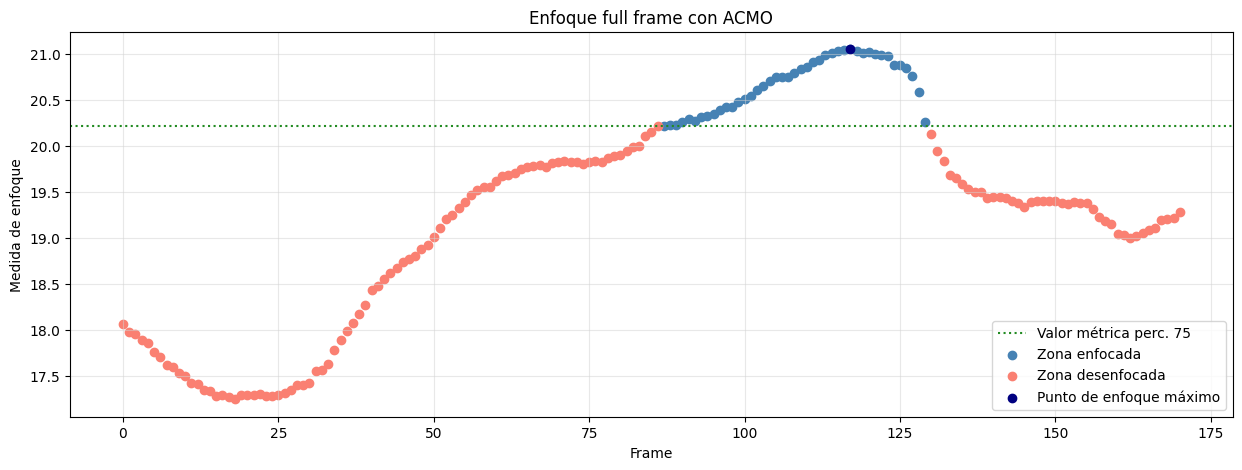

Valor de métrica: 20.2144 

     frame         FM
87      87  20.218983
88      88  20.223305
89      89  20.222074
90      90  20.260979
91      91  20.288816
92      92  20.270176
93      93  20.308093
94      94  20.323349
95      95  20.341007
96      96  20.386323
97      97  20.417830
98      98  20.422775
99      99  20.469104
100    100  20.509761
101    101  20.543727
102    102  20.600115
103    103  20.651333
104    104  20.698466
105    105  20.746555
106    106  20.747874
107    107  20.747122
108    108  20.794292
109    109  20.829852
110    110  20.856308
111    111  20.908902
112    112  20.934745
113    113  20.985230
114    114  21.007956
115    115  21.031368
116    116  21.038148
117    117  21.047174
118    118  21.023935
119    119  21.007965
120    120  21.021975
121    121  20.991786
122    122  20.979051
123    123  20.976711
124    124  20.873918
125    125  20.877764
126    126  20.842677
127    127  20.755878
128    128  20.581993
129    129  20.261667


In [28]:
# Se procesa el video
exp1_ACMO = process_video_FULL_ACMO('focus_video.mov')

# Se calculan las métricas y los frames enfocados
metrica_ACMO, df_enfoqueACMO = enfoque_video(FM = exp1_ACMO, perc=75, plot=True, title_plot='Enfoque full frame con ACMO', 
                                    focus_color= 'steelblue', desenfoc_color='salmon')
print(f'Valor de métrica: {np.round(metrica_ACMO,4)} \n')
print(df_enfoqueACMO)

In [29]:
# ---------------- Reproducción del video ----------------

# Carga del video
video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)


if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))

    # Si hay que redimensionar, lo hacemos acá
    new_width = frame_width // 1
    new_height = frame_height // 1
    
    # Se obtiene la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    

    # Loop para detectar zonas enfocadas / desenfocadas
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        bbox_start = (0, new_height)
        bbox_end = (new_width, 0)
        
        if i in df_enfoqueACMO['frame']:
            # Se muestra el frame verde en caso de máximo enfoque
            cv.rectangle(frame, bbox_start, bbox_end, (0,255,0),10)
        else:
            # Se muestra el frame rojo si no está en condición de máximo enfoque
            cv.rectangle(frame, bbox_start, bbox_end, (0,0,255), 10)
        
        cv.imshow('Medicion de enfoque en full frame ACMO', frame)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break
        

# Se libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

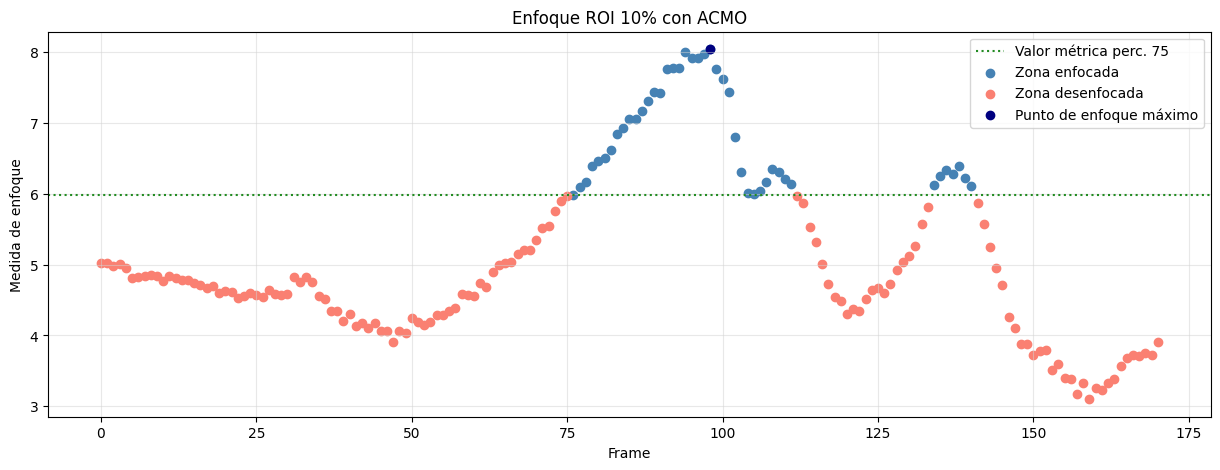

Valor de métrica: 5.9794 

     frame        FM
76      76  5.981811
77      77  6.103048
78      78  6.175004
79      79  6.392892
80      80  6.463235
81      81  6.507065
82      82  6.622244
83      83  6.840400
84      84  6.930599
85      85  7.054370
86      86  7.053964
87      87  7.165374
88      88  7.318428
89      89  7.433989
90      90  7.423142
91      91  7.764806
92      92  7.773063
93      93  7.774118
94      94  8.009172
95      95  7.917349
96      96  7.915942
97      97  7.971550
98      98  8.044253
99      99  7.766472
100    100  7.621288
101    101  7.435424
102    102  6.808306
103    103  6.314836
104    104  6.007938
105    105  5.992579
106    106  6.042664
107    107  6.173729
108    108  6.351950
109    109  6.315457
110    110  6.207610
111    111  6.132785
134    134  6.130874
135    135  6.247079
136    136  6.333986
137    137  6.285007
138    138  6.393759
139    139  6.221508
140    140  6.113200


In [30]:
# Se procesa el video
ROI_size = 0.1
exp2_ACMO = process_video_ROI_ACMO('focus_video.mov', size=ROI_size)

metrica_ACMO, df_enfoque_ACMO = enfoque_video(FM = exp2_ACMO, perc=75, plot=True, title_plot= 'Enfoque ROI 10% con ACMO', 
                                    focus_color= 'steelblue', desenfoc_color='salmon')
print(f'Valor de métrica: {np.round(metrica_ACMO,4)} \n')
print(df_enfoque_ACMO)


In [31]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)


if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)

    # Punto medio para ubicar ROI
    med_h = frame_height // 2
    med_w = frame_width // 2

    # ROI
    area_ROI_h = int(ROI_size * frame_height)  # Area de ROI = 10% del total
    area_ROI_w = int(ROI_size * frame_width)

    min_height = med_h - (area_ROI_h // 2)
    max_height = med_h + (area_ROI_h // 2)
    min_width =  med_w - (area_ROI_w // 2)
    max_width =  med_w + (area_ROI_w // 2)
    
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)
    
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        bbox_start = (min_width, max_height)
        bbox_end = (max_width, min_height)
        
        # Si el frame está enfocado aparece en verde, sino en rojo
        if i in df_enfoque_ACMO['frame']:
            cv.rectangle(frame, bbox_start, bbox_end, (0,255,0),2)
        else:
            cv.rectangle(frame, bbox_start, bbox_end, (0,0,255), 2)
        
        cv.imshow('Medicion de enfoque en ROI 10% con ACMO', frame)

        i += 1

        # Para salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break
        

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv.destroyAllWindows()

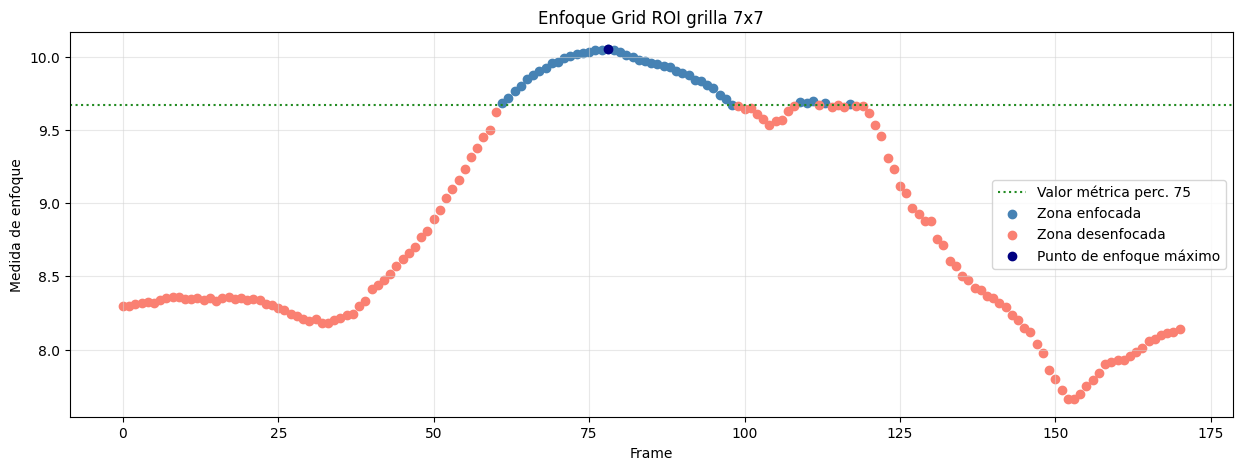

Valor de métrica: 9.6722 

     frame         FM
61      61   9.687079
62      62   9.718180
63      63   9.763950
64      64   9.800263
65      65   9.845387
66      66   9.874595
67      67   9.905514
68      68   9.925549
69      69   9.953962
70      70   9.966712
71      71   9.994395
72      72  10.004650
73      73  10.017853
74      74  10.022170
75      75  10.031915
76      76  10.043538
77      77  10.045414
78      78  10.051065
79      79  10.042628
80      80  10.029776
81      81  10.011738
82      82  10.000198
83      83   9.975849
84      84   9.968729
85      85   9.958564
86      86   9.949304
87      87   9.934566
88      88   9.926646
89      89   9.899065
90      90   9.886197
91      91   9.875931
92      92   9.844079
93      93   9.831179
94      94   9.807984
95      95   9.784518
96      96   9.737936
97      97   9.711823
98      98   9.672244
109    109   9.690965
110    110   9.683586
111    111   9.695669
113    113   9.685388
117    117   9.680240


In [32]:
# Se procesa el video
N = 7
M = 7
exp3_ACMO = process_video_gridROI_ACMO('focus_video.mov', N = N, M = M)
exp3_ACMO

# Se calculan las métricas y los frames enfocados
metrica_ACMO, df_enfoque_ACMO = enfoque_video(FM = exp3_ACMO, perc=75, plot=True, title_plot= 'Enfoque Grid ROI grilla 7x7', focus_color='steelblue', desenfoc_color='salmon')
print(f'Valor de métrica: {np.round(metrica_ACMO,4)} \n')
print(df_enfoque_ACMO)

In [33]:
# ---------------- Reproducción del video ----------------

video_path = 'focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Dimensiones del video
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
  
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    fps = 20
    delay = int(1000 / fps)

    i = 0

    while captura_video.isOpened():
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Se dibuja la grilla de color verde si está enfocada, en caso contrario en rojo
        if i in df_enfoque_ACMO['frame']:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 255, 0))
        else:
            frame_with_grid = draw_spaced_grid(frame, num_rows = N, num_cols = M, color=(0, 0, 255))

        cv.imshow('Medicion de enfoque en grilla equiespaciada 7x7 con ACMO', frame_with_grid)

        i += 1

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break   

captura_video.release()
cv.destroyAllWindows()